# Training and Detection

IMPORTANT: all instructions assume __no__ GUI leveraging

## A. Some pre-work

1. am I using the venv python version?
2. am I in the expected directory?

In [30]:
# make sure you are in your venv and using the correct python version
!!python --version

['Python 3.9.13']

In [40]:
# make sure you are in the project_1 directory
import os
os.getcwd()

'/Users/ahalte200/Git_Repositories_Other/TFODCourse/project_1'

<a id="paths_and_filenames"></a>
## B. Define paths and filenames

In [1]:
import os

In [96]:
# Filenames

# starting Tensorflow Model Garden model and where to find it
# (model name should match filename)
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'\
    + PRETRAINED_MODEL_NAME + '.tar.gz'

# my custom model
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet_model'

# script for generating TF records
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'

LABEL_MAP_NAME = 'label_map.pbtxt'

In [116]:
# Directory Paths

# using os makes these paths usable in any OS
PATHS = {
    'WORKSPACE' : os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS' : os.path.join('Tensorflow', 'scripts'),
    'TF_MODEL_GARDEN' : os.path.join('Tensorflow', 'models'),
    'ANNOTATIONS' : os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGES' : os.path.join('Tensorflow', 'workspace', 'images'),
    'MODELS' : os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODELS' : os.path.join('Tensorflow', 'workspace', 'pretrained_models'),
    'CHECKPOINTS' : os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT' : os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFJS' : os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE' : os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC' : os.path.join('Tensorflow', 'protoc')
}

In [117]:
# File Paths

FILES = {
    'PIPELINE_CONFIG' : os.path.join(PATHS['CHECKPOINTS'], 'pipeline.config'),
    'TF_RECORD_SCRIPT' : os.path.join(PATHS['SCRIPTS'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP' : os.path.join(PATHS['ANNOTATIONS'], LABEL_MAP_NAME)
}

[Go to the Training Section](#training) if you have already set up your directories and installed TF/TFOD.

### Create directories

This only needs to be done once

In [16]:
for path in PATHS.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        elif os.name == 'nt':
            !mkdir {path}

## C. Installing TensorFlow

1. Windows users enable Win32 long paths
2. Install TensorFlow
3. Test TensorFlow installation

### 1. (Windows users only) enable Win32 long paths

Different Windows OS have different methods. For Windows 10 I did this through the Regedit settings [using the Windows Club directions](https://www.thewindowsclub.com/how-to-enable-or-disable-win32-long-paths-in-windows-11-10)

1. Type `RegEdit` in the start menu
2. Paste the following into the address bar and click "Enter".
`HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem`
3. Double click on `LongPathsEnabled` in the FileSystem folder.
4. Change Value Data to `1` (default is `0`) and click "OK"

_Reference images:
<div>
    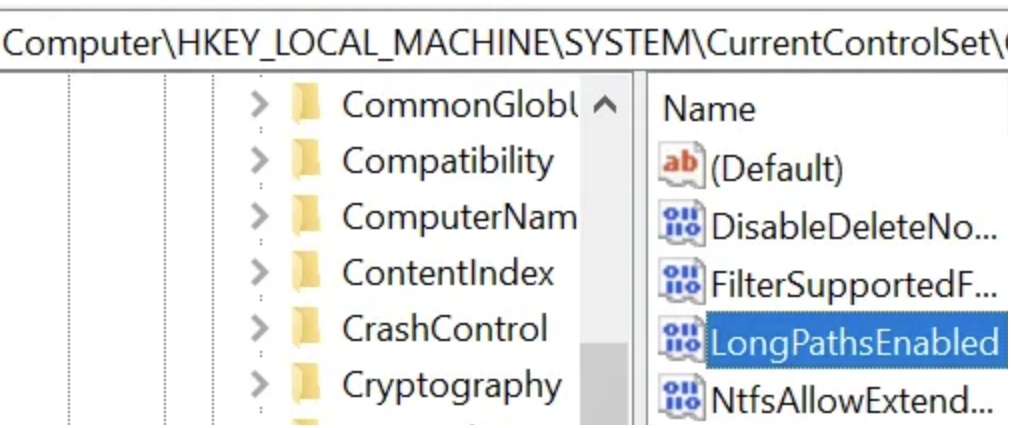
</div>
<div>
    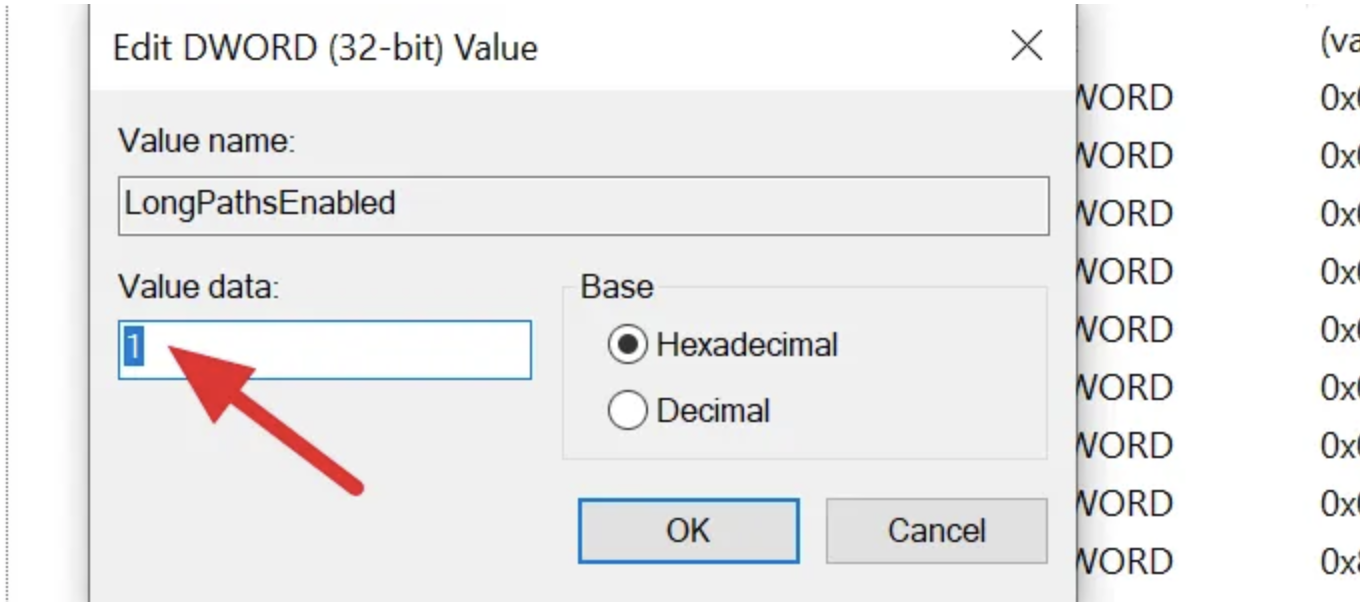
</div>


### 2. Install TensorFlow

In [31]:
# upgrade pip
!pip install --upgrade pip

In [32]:
# install TensorFlow
!pip install --upgrade tensorflow

### 3. Test TensorFlow
You should receive tensor back such as:

`tf.Tensor(-522.1346, shape=(), dtype=float32)`

In [34]:
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

2022-09-11 14:43:37.987903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 14:43:43.048392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
tf.Tensor(-522.1346, shape=(), dtype=float32)


## D. Learn about the starting model
* We will use a starting model from the [Tensorflow Model Garden](https://github.com/tensorflow/models) on GitHub
* We will pick ours from the [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) 
(research > object_detection > TensorFlow 2 Detection Model Zoo)
* balancing speed and accuracy we will use [SSD MobileNet V2 FPNLite 320x320](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz)


## E. Tensorflow Model Zoo and Object Detection (TFOD) Installation

We will need two things out of the TF Model Zoo:
* TFOD supporting files
* The starting model

Therefore we will need to have a full clone of the TF Model Zoo

We will:

1. Clone the TF Model Garden
2. Install Protoc
3. Install TF Object Detection
4. Import TFOD to ensure all dependencies have been resolved

### 1. Clone the Tensorflow Model Garden

We will be needing the Object Detection directory from this repository so we will clone the entire repository into the api_models folder

In [19]:
# check for the object_detection directory in the Tensorflow/models directory
if not os.path.exists(os.path.join(PATHS['TF_MODEL_GARDEN'], 'research', 'object_detection')):
    # if it doesn't exist clone the TF Model Garden
    !git clone https://github.com/tensorflow/models.git {PATHS['TF_MODEL_GARDEN']}

In [25]:
# create a text file to tag Tensorflow/models as the Tensorflow Model Garden
# and another to tag Tensorflow/workspace/models as my models

!echo "This directory contains the Tensorflow Model Garden" > {os.path.join(PATHS['TF_MODEL_GARDEN'], '_DIR_IS_TENSORFLOW_MODEL_GARDEN.txt')}
!echo "This directory contains my trained models" > {os.path.join(PATHS['MODELS'], '_DIR_IS_MY_TRAINED_MODELS.txt')}


### 2. Installing Protoc

#### About protocol buffers

From [Wikipedia's article on protocol buffers](https://en.wikipedia.org/wiki/Protocol_Buffers):

_Google created protocol buffers (aka __protoc__ or __protobuf__) for __storing and interchanging__ all kinds of __structured information__._

_It is a __data format__ used __to serialize structured data__. It is useful in developing programs to communicate with each other over a network or for storing data._

_The method involves an __interface description language__ that describes the structure of some data __and__ a __program that generates source code__ from that description for generating or parsing a stream of bytes that represents the structured data._

Protocol buffers will be used by Tensorflow object detection.  Therefore we need to install the __protobuf compiler__ in order to __create \_pb2.py__ files from the __.proto__ files

#### My installation method

We will install protoc by hand rather than using a package manager.  That way we can choose the version.  I will be using version 3.15.8 even though 3.21.5 is now out.  This is because of problems with the latest versions when trying to validate.

[Here is a good example of one of the problems](https://groups.google.com/g/protobuf/c/Daii9Nj87C4)

So I will be using a command-line method rather than Homebrew to install for Mac/Linux.

We will:
1. Install `wget` for Windows users
2. Install protoc

#### i. Install `wget` package for Windows:

The Python package __wget__ is a utility __to download remote files__ from the internet.  This ability is built into Linux/Mac OS but is not built into Windows.

In [17]:
# install wget package
if os.name == 'nt':
    !pip install --upgrade wget

In [18]:
# import wget
if os.name =='nt':
    import wget

#### ii. Install protoc

In [ ]:
# change the following version paths and filenames as needed
PROTOC_URL = 'https://github.com/protocolbuffers/protobuf/releases/download/v3.15.8/'
PROTOC_ZIP_FILE = {
    'mac' : 'protoc-3.15.8-osx-x86_64.zip',
    'linux' : 'protoc-3.15.8-linux-x86_64.zip', # assuming 64-bit
    'windows' : 'protoc-3.15.8-win64.zip' # assuming 64-bit
}
if os.name == 'posix':
    # (change mac to linux if need be)
    !curl -OL {PROTOC_URL}{PROTOC_ZIP_FILE['mac']}
    !sudo unzip -o {PROTOC_ZIP_FILE['mac']} -d /usr/local bin/protoc
    !sudo unzip -o {PROTOC_ZIP_FILE['mac']} -d /usr/local 'include/*'
    !rm -f {PROTOC_ZIP_FILE['mac']}
elif os.name == 'nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(PROTOC_URL + PROTOC_ZIP_FILE['windows'])
    !move {PROTOC_ZIP_FILE['windows']} {paths['PROTOC']}
    !cd {PATHS['PROTOC']}\
        && tar -xf PROTOC_ZIP_FILE['windows']
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(PATHS['PROTOC'], 'bin'))   

In [73]:
!protoc --version

libprotoc 3.15.8


### 3. Installing TensorFlow Object Detection (TFOD)

1. compile protos
2. install TF Object Detection API
3. test for successful installation

#### i. Compile protos

In [75]:
!cd Tensorflow/models/research\
        && protoc object_detection/protos/*.proto --python_out=.\

#### ii. Install TF Object Detection API

In [76]:
if os.name == 'posix':
    !cd Tensorflow/models/research\
        && cp object_detection/packages/tf2/setup.py .\
        && python -m pip install --use-feature=2020-resolver .
elif os.name == 'nt':
    !cd Tensorflow/models/research\&& copy object_detection\\packages\\tf2\\setup.py setup.py\
        && python setup.py build\
        && python setup.py install
    !cd Tensorflow/models/research/slim\
        && pip install -e .

Processing /Users/ahalte200/Git_Repositories_Other/TFODCourse/project_1/Tensorflow/models/research
  Preparing metadata (setup.py) ... done


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1695995 sha256=997a6e963eb7b7a525a33a1e5f9fe9e3c36073453ace36cef6261feb175b433c
  Stored in directory: /private/var/folders/bq/fvvldy095vz80qbkf7d8zz2h0000gp/T/pip-ephem-wheel-cache-kqlgcicr/wheels/73/58/24/9981550787ea7f25d808d3fba293a0d11f569c3a7cb82f383f
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


#### iii. Test that TFOD installation was successful

Successful test will result in:

```
Ran 24 tests in 31.489s
OK (skipped=1)
```

If you get __any errors__ regarding uninstalled __packages__, just __install__ them and run again.

In [78]:
VERIFICATION_SCRIPT = os.path.join(PATHS['TF_MODEL_GARDEN'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.9.13: /Users/ahalte200/Git_Repositories_Other/TFODCourse/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-09-12 17:54:44.335426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ahalte200/Git_Repositories_Other/TFODCourse/lib/python3.9/site-packages/object_detection/builders/model_builder.py:1102: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W0912 17:54:44.759690 4466136576 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 0.74s
I0912 17:54:45.05

I0912 17:54:49.189466 4466136576 efficientnet_model.py:143] round_filter input=40 output=40
I0912 17:54:49.189605 4466136576 efficientnet_model.py:143] round_filter input=80 output=80
I0912 17:54:49.379176 4466136576 efficientnet_model.py:143] round_filter input=80 output=80
I0912 17:54:49.379278 4466136576 efficientnet_model.py:143] round_filter input=112 output=112
I0912 17:54:49.567479 4466136576 efficientnet_model.py:143] round_filter input=112 output=112
I0912 17:54:49.567585 4466136576 efficientnet_model.py:143] round_filter input=192 output=192
I0912 17:54:49.897979 4466136576 efficientnet_model.py:143] round_filter input=192 output=192
I0912 17:54:49.898143 4466136576 efficientnet_model.py:143] round_filter input=320 output=320
I0912 17:54:50.039617 4466136576 efficientnet_model.py:143] round_filter input=1280 output=1280
I0912 17:54:50.107962 4466136576 efficientnet_model.py:453] Building model efficientnet with params ModelConfig(width_coefficient=1.0, depth_coefficient=1.0, 

I0912 17:54:55.238750 4466136576 ssd_efficientnet_bifpn_feature_extractor.py:145] EfficientDet EfficientNet backbone version: efficientnet-b3
I0912 17:54:55.238857 4466136576 ssd_efficientnet_bifpn_feature_extractor.py:147] EfficientDet BiFPN num filters: 160
I0912 17:54:55.238909 4466136576 ssd_efficientnet_bifpn_feature_extractor.py:148] EfficientDet BiFPN num iterations: 6
I0912 17:54:55.240392 4466136576 efficientnet_model.py:143] round_filter input=32 output=40
I0912 17:54:55.252656 4466136576 efficientnet_model.py:143] round_filter input=32 output=40
I0912 17:54:55.252752 4466136576 efficientnet_model.py:143] round_filter input=16 output=24
I0912 17:54:55.355499 4466136576 efficientnet_model.py:143] round_filter input=16 output=24
I0912 17:54:55.355607 4466136576 efficientnet_model.py:143] round_filter input=24 output=32
I0912 17:54:55.544433 4466136576 efficientnet_model.py:143] round_filter input=24 output=32
I0912 17:54:55.544560 4466136576 efficientnet_model.py:143] round_fil

I0912 17:55:01.077158 4466136576 efficientnet_model.py:143] round_filter input=24 output=40
I0912 17:55:01.077373 4466136576 efficientnet_model.py:143] round_filter input=40 output=64
I0912 17:55:01.693738 4466136576 efficientnet_model.py:143] round_filter input=40 output=64
I0912 17:55:01.694000 4466136576 efficientnet_model.py:143] round_filter input=80 output=128
I0912 17:55:02.391510 4466136576 efficientnet_model.py:143] round_filter input=80 output=128
I0912 17:55:02.391613 4466136576 efficientnet_model.py:143] round_filter input=112 output=176
I0912 17:55:02.873342 4466136576 efficientnet_model.py:143] round_filter input=112 output=176
I0912 17:55:02.873521 4466136576 efficientnet_model.py:143] round_filter input=192 output=304
I0912 17:55:03.610195 4466136576 efficientnet_model.py:143] round_filter input=192 output=304
I0912 17:55:03.610332 4466136576 efficientnet_model.py:143] round_filter input=320 output=512
I0912 17:55:04.017750 4466136576 efficientnet_model.py:143] round_fi

I0912 17:55:15.278559 4466136576 efficientnet_model.py:143] round_filter input=1280 output=2560
I0912 17:55:15.346510 4466136576 efficientnet_model.py:453] Building model efficientnet with params ModelConfig(width_coefficient=2.0, depth_coefficient=3.1, resolution=600, dropout_rate=0.5, blocks=(BlockConfig(input_filters=32, output_filters=16, kernel_size=3, num_repeat=1, expand_ratio=1, strides=(1, 1), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=16, output_filters=24, kernel_size=3, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=24, output_filters=40, kernel_size=5, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=40, output_filters=80, kernel_size=3, num_repeat=3, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv

### 4. Import object_detection

Test importing the TFOD package.  If it doesn't work you may need to completely restart your kernel.

In [79]:
import object_detection

<a id="training"></a>
## F. Prep for Training

IMPORTANT: Always [define filenames and pathways](#paths_and_filenames) before continuing

In [84]:
import object_detection
import os
if os.name =='nt':
    import wget

### 1. Download our starting model from the TF Model Zoo

In [91]:
if os.name == 'posix':
    !curl -OL {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME + '.tar.gz'} {PATHS['PRETRAINED_MODELS']}
    !cd {PATHS['PRETRAINED_MODELS']} && tar -zxvf {PRETRAINED_MODEL_NAME + '.tar.gz'}
elif os.name == 'nt':
    import wget
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME + '.tar.gz'} {PATHS['PRETRAINED_MODELS']}
    !cd {PATHS['PRETRAINED_MODELS']} && tar -zxvf {PRETRAINED_MODEL_NAME + '.tar.gz'}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.5M  100 19.5M    0     0  2257k      0  0:00:08  0:00:08 --:--:-- 2572k
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_m

### 2. Create Label Map
Create a `.pbtxt` (protobuf text file) that contains label definition in a readable (text) __protobuf format__

It will look like this:
<div>
    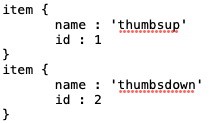
</div>

In [100]:
# make sure your label names are correct including case
# or you will get an error when generating tfrecords
labels = [
    {'name' : 'thumbsup', 'id' : 1},
    {'name' : 'thumbsdown', 'id' : 2},
    {'name' : 'thankyou', 'id' : 3},
    {'name' : 'livelong', 'id' : 4},
]

with open(FILES['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item {\n')
        f.write('\tname : \'{}\'\n'.format(label['name']))
        f.write('\tid : {}\n'.format(label['id']))
        f.write('}\n')

### 3. Create TFRecords

 * TFRecords are a binary file format for storing data.
 * Using a TFRecord helps speed up training for your custom object detection model.
 * We will create tfrecord files (`.record`) for train and test
 * Will be using Nicholas Renotte's `generate_tfrecord.py` to generate the tfrecord files

In [101]:
# clone Nicholas Renotte's generate_tfrecord.py
if not os.path.exists(FILES['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord.git {PATHS['SCRIPTS']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [102]:
# generate the tfrecords for train and test
# KeyError usually means label names were incorrect
!python {FILES['TF_RECORD_SCRIPT']} -x {os.path.join(PATHS['IMAGES'], 'train')} -l {FILES['LABELMAP']} -o {os.path.join(PATHS['ANNOTATIONS'], 'train.record')} 
!python {FILES['TF_RECORD_SCRIPT']} -x {os.path.join(PATHS['IMAGES'], 'test')} -l {FILES['LABELMAP']} -o {os.path.join(PATHS['ANNOTATIONS'], 'test.record')} 


Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


### 4. Configure the Model
`pipeline.config` defines the __architecture of the model__.  It is found in the pretrained model (from TF Model Zoo) and needs to be customized for our model.

Architecture characteristics of `pipeline.config`:

<div>
    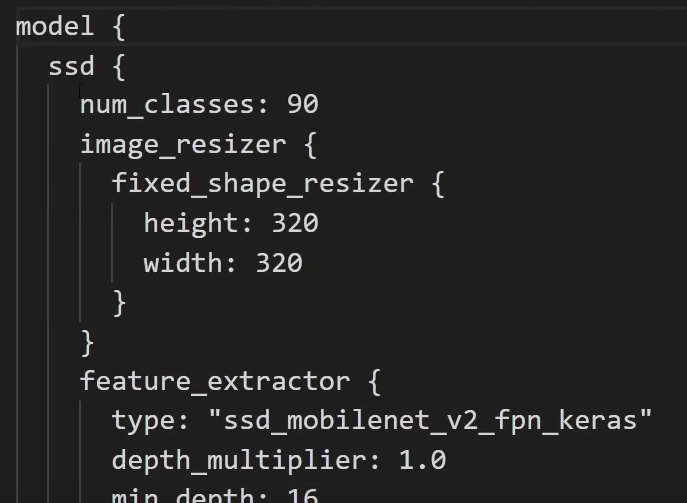
</div>

Some of its __features__:

* num_classes (ours will be 4 -- thumbsup, thumbsdown, thankyou, livelong)
* image_resizer (to 320 x 320)
* feature_extractor
* data_augmentation_options (it does data augmentation for us)

We will need to __update__ all instances of __"PATH_TO_BE_CONFIGURED"__

We will:
1. copy the `pipeline.config` into our own models directory
2. update our copy of `pipeline.config`

#### i. copy model config file to training folder

In [104]:
if os.name =='posix':
    !cp {os.path.join(PATHS['PRETRAINED_MODELS'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(PATHS['CHECKPOINTS'])}
if os.name == 'nt':
    !copy {os.path.join(PATHS['PRETRAINED_MODELS'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(PATHS['CHECKPOINTS'])}
    

#### ii. update config file for transfer learning

In [105]:
# import required packages
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [106]:
config = config_util.get_configs_from_pipeline_file(FILES['PIPELINE_CONFIG'])


In [109]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [110]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(FILES['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [111]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(PATHS['PRETRAINED_MODELS'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= FILES['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(PATHS['ANNOTATIONS'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = FILES['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(PATHS['ANNOTATIONS'], 'test.record')]


In [113]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(FILES['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

## G. Train the model

You can run the training either from Jupyter Notebook or from terminal.

Running from terminal allows you to see the status of your training, especially in Windows.

Therefore we will generate the command and you can either copy it and paste it to terminal/command prompt, or run it right in Jupyter.  Your choice.

In [115]:
TRAINING_SCRIPT = os.path.join(PATHS['TF_MODEL_GARDEN'], 'research', 'object_detection', 'model_main_tf2.py')


In [118]:
train_command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, PATHS['CHECKPOINTS'], FILES['PIPELINE_CONFIG'])


In [119]:
print(train_command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobilenet_model --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobilenet_model/pipeline.config --num_train_steps=2000


In [120]:
# either copy the above command to run in terminal/cmd prompt
# or just run the command from Jupyter Notebook below
!{train_command}

2022-09-13 15:26:45.254360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0913 15:26:45.263585 4713137664 cross_device_ops.py:1386] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0913 15:26:45.441426 4713137664 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0913 15:26:45.452807 4713137664 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0913 15:26:45.452966 4713137664 config_util.py:552] Maybe overwriting use_b

INFO:tensorflow:Step 200 per-step time 1.014s
I0913 15:31:15.154726 4713137664 model_lib_v2.py:705] Step 200 per-step time 1.014s
INFO:tensorflow:{'Loss/classification_loss': 0.29403523,
 'Loss/localization_loss': 0.22948745,
 'Loss/regularization_loss': 0.15478414,
 'Loss/total_loss': 0.6783068,
 'learning_rate': 0.0373328}
I0913 15:31:15.155096 4713137664 model_lib_v2.py:708] {'Loss/classification_loss': 0.29403523,
 'Loss/localization_loss': 0.22948745,
 'Loss/regularization_loss': 0.15478414,
 'Loss/total_loss': 0.6783068,
 'learning_rate': 0.0373328}
INFO:tensorflow:Step 300 per-step time 0.992s
I0913 15:32:54.401814 4713137664 model_lib_v2.py:705] Step 300 per-step time 0.992s
INFO:tensorflow:{'Loss/classification_loss': 0.22507949,
 'Loss/localization_loss': 0.19500318,
 'Loss/regularization_loss': 0.15463945,
 'Loss/total_loss': 0.5747222,
 'learning_rate': 0.0426662}
I0913 15:32:54.402055 4713137664 model_lib_v2.py:708] {'Loss/classification_loss': 0.22507949,
 'Loss/localizat

INFO:tensorflow:Step 1700 per-step time 0.931s
I0913 15:54:30.677824 4713137664 model_lib_v2.py:705] Step 1700 per-step time 0.931s
INFO:tensorflow:{'Loss/classification_loss': 0.04666338,
 'Loss/localization_loss': 0.026194226,
 'Loss/regularization_loss': 0.1465751,
 'Loss/total_loss': 0.2194327,
 'learning_rate': 0.07995972}
I0913 15:54:30.678068 4713137664 model_lib_v2.py:708] {'Loss/classification_loss': 0.04666338,
 'Loss/localization_loss': 0.026194226,
 'Loss/regularization_loss': 0.1465751,
 'Loss/total_loss': 0.2194327,
 'learning_rate': 0.07995972}
INFO:tensorflow:Step 1800 per-step time 0.931s
I0913 15:56:03.790859 4713137664 model_lib_v2.py:705] Step 1800 per-step time 0.931s
INFO:tensorflow:{'Loss/classification_loss': 0.09257109,
 'Loss/localization_loss': 0.035182927,
 'Loss/regularization_loss': 0.14580117,
 'Loss/total_loss': 0.2735552,
 'learning_rate': 0.0799474}
I0913 15:56:03.791105 4713137664 model_lib_v2.py:708] {'Loss/classification_loss': 0.09257109,
 'Loss/lo

## H. Evaluate the Model

After you have run your training, copy the following printed evaluation command and run in terminal/command prompt.  Alternately you can run it directly in Jupyter Notebook if it lets you view the results.

In [121]:
eval_command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, PATHS['CHECKPOINTS'],FILES['PIPELINE_CONFIG'], PATHS['CHECKPOINTS'])


In [122]:
print(eval_command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobilenet_model --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobilenet_model/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobilenet_model


In [ ]:
# Either copy the above model eval command and paste into terminal/command prompt
# or run it from Jupyter Notebook here
!{eval_command}
# might be better to run in terminal/command prompt
# since you will need to ^C to exit it.
# Better than stopping the Kernel

## I. Import Trained Model from Checkpoint
* Note what checkpoint we got up to (checkpoints found in my_ssd_mobilenet_model).
* In the code, change the checkpoint to the correct one (i.e. `ckpt-3`)

In [123]:
# import necessary packages
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [124]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(FILES['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Import my latest checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATHS['CHECKPOINTS'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2022-09-13 17:02:36.668893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## J. Detect from an Image

In [125]:
#import necessary packages
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [126]:
category_index = label_map_util.create_category_index_from_labelmap(FILES['LABELMAP'])


In [127]:
# use one of the train/test images to use or get another image
name_of_image = 'livelong.02533422-940e-11eb-9dbd-5cf3709bbcc6.jpg'
IMAGE_PATH = os.path.join(PATHS['IMAGES'], 'test', name_of_image)


In [128]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

[ WARN:0@251.515] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('Tensorflow/workspace/images/test/livelong.02533422-940e-11eb-9dbd-5cf3709bbcc6.jpg'): can't open/read file: check file path/integrity


ValueError: in user code:

    File "/var/folders/bq/fvvldy095vz80qbkf7d8zz2h0000gp/T/ipykernel_8634/2982441114.py", line 11, in detect_fn  *
        image, shapes = detection_model.preprocess(image)
    File "/Users/ahalte200/Git_Repositories_Other/TFODCourse/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 484, in preprocess  *
        normalized_inputs, self._image_resizer_fn)
    File "/Users/ahalte200/Git_Repositories_Other/TFODCourse/lib/python3.9/site-packages/object_detection/utils/shape_utils.py", line 492, in resize_images_and_return_shapes  *
        outputs = static_or_dynamic_map_fn(
    File "/Users/ahalte200/Git_Repositories_Other/TFODCourse/lib/python3.9/site-packages/object_detection/utils/shape_utils.py", line 246, in static_or_dynamic_map_fn  *
        outputs = [fn(arg) for arg in tf.unstack(elems)]
    File "/Users/ahalte200/Git_Repositories_Other/TFODCourse/lib/python3.9/site-packages/object_detection/core/preprocessor.py", line 3330, in resize_image  *
        new_image = tf.image.resize_images(

    ValueError: 'images' must have either 3 or 4 dimensions.
